## Exercise 4
### Task 2

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt, log, exp, pi
from random import uniform

# Load the Old Faithful Geyser Data
data = np.loadtxt("faithful.dat", skiprows=26, usecols=(1,)) # Only column 1: duration of the eruption

(a) Implement the Expectation Maximisation algorithm for fitting a one-dimensional Gaussian mixture model to data points. Test your implementation with the Old Faithful Geyser Data set by considering only the duration of the eruption.

In [45]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    #printing model values
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [46]:
class GaussianMixture:
    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        self.one = Gaussian(uniform(mu_min, mu_max), uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), uniform(sigma_min, sigma_max))
        self.mix = mix

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)

    def Estep(self):
        self.loglike = 0.
        for datum in self.data:
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            den = wp1 + wp2
            wp1 /= den
            wp2 /= den
            self.loglike += log(wp1 + wp2)
            yield (wp1, wp2)

    def Mstep(self, weights):
        (left, right) = zip(*weights)
        one_den = sum(left)
        two_den = sum(right)
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, self.data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(right, self.data))
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2) for (w, d) in zip(left, self.data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2) for (w, d) in zip(right, self.data)) / two_den)
        self.mix = one_den / len(self.data)

    def iterate(self, N=10, verbose=False):
        for i in range(1, N+1):
            self.Estep()
            self.Mstep(self.Estep())
            if verbose:
                print(f"Iteration {i}, Log-likelihood: {self.loglike}")

In [47]:
# Initialize with a random Gaussian Mixture
mix = GaussianMixture(data)

# Perform EM with verbose output
mix.iterate(N=20, verbose=True)

Iteration 1, Log-likelihood: -3.3306690738754696e-15
Iteration 2, Log-likelihood: -2.3314683517128287e-15
Iteration 3, Log-likelihood: -2.220446049250313e-15
Iteration 4, Log-likelihood: -2.886579864025407e-15
Iteration 5, Log-likelihood: -1.5543122344752192e-15
Iteration 6, Log-likelihood: -3.1086244689504383e-15
Iteration 7, Log-likelihood: -2.886579864025407e-15
Iteration 8, Log-likelihood: -5.662137425588298e-15
Iteration 9, Log-likelihood: -4.107825191113079e-15
Iteration 10, Log-likelihood: -3.219646771412954e-15
Iteration 11, Log-likelihood: -3.1086244689504383e-15
Iteration 12, Log-likelihood: -5.662137425588298e-15
Iteration 13, Log-likelihood: -4.9960036108132044e-15
Iteration 14, Log-likelihood: -3.552713678800501e-15
Iteration 15, Log-likelihood: -4.9960036108132044e-15
Iteration 16, Log-likelihood: -1.4432899320127035e-15
Iteration 17, Log-likelihood: -2.7755575615628914e-15
Iteration 18, Log-likelihood: -2.1094237467877974e-15
Iteration 19, Log-likelihood: -2.553512956637

In [48]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 100
best_mix = None
best_loglike = float('-inf')

print('Algorithm with random restarts...\n')

for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning):  # Catch errors from bad starts
            pass

print('\n\nBest model computed:\n')

Algorithm with random restarts...



Best model computed:



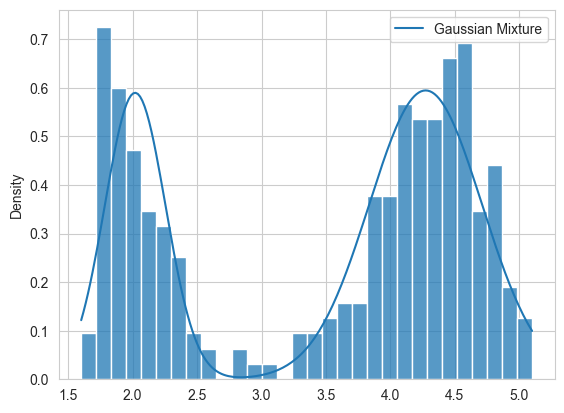

In [49]:
# Generate x values for plotting, based on range in data
x = np.linspace(min(data), max(data), 200)

# Plot histogram of data
sns.histplot(data, bins=30, kde=False, stat='density')

# Plot Gaussian mixture model
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='Gaussian Mixture')
plt.legend()
plt.show()

(b) Try the fitting with different initialisations and visualise the estimation results. Show both an example when the algorithm converges to a good solution and when it fails. Can you explain why it fails sometimes?

Trial 1


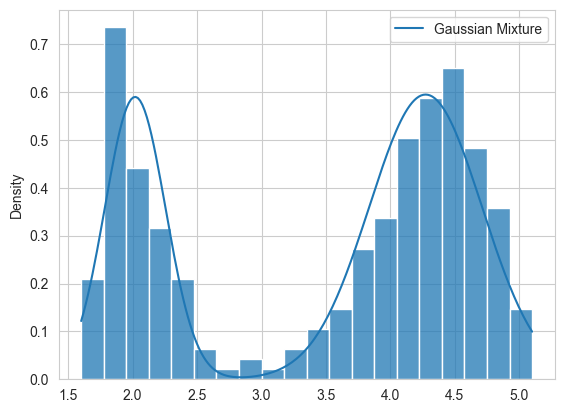

Trial 2


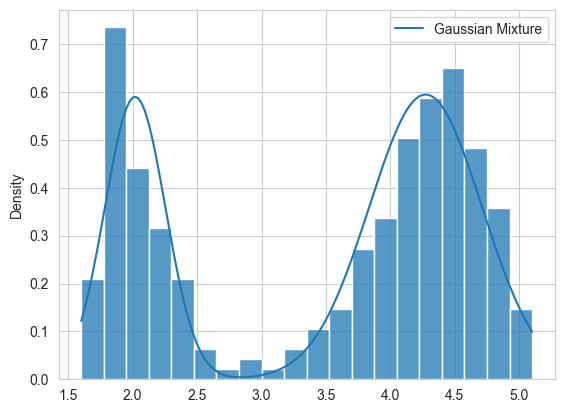

Trial 3


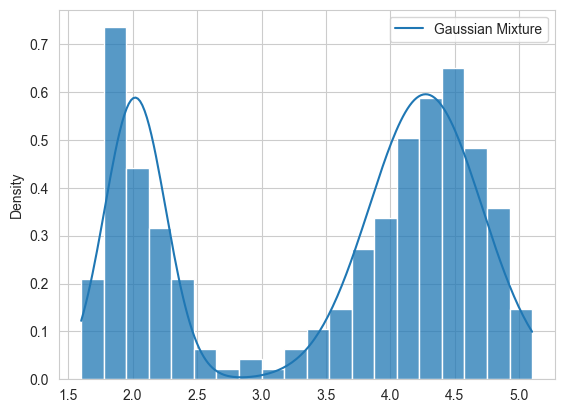

Trial 4


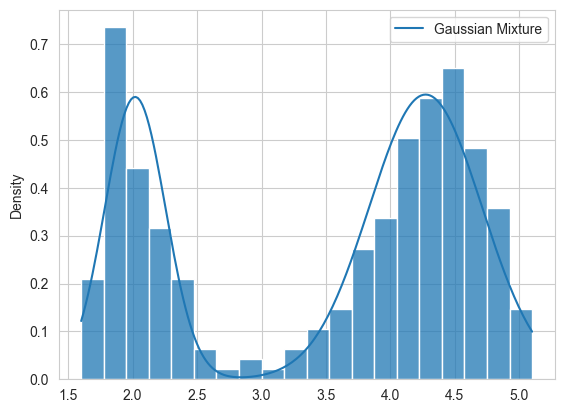

Trial 5


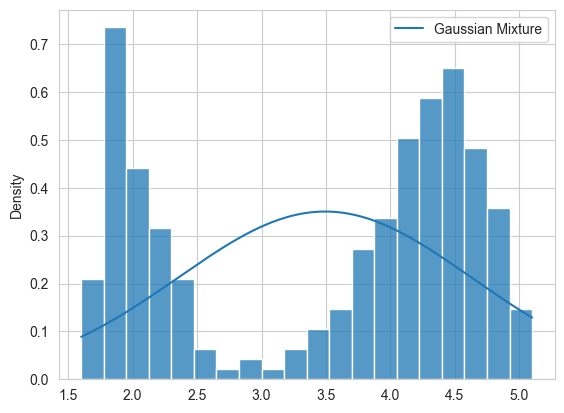

Trial 6


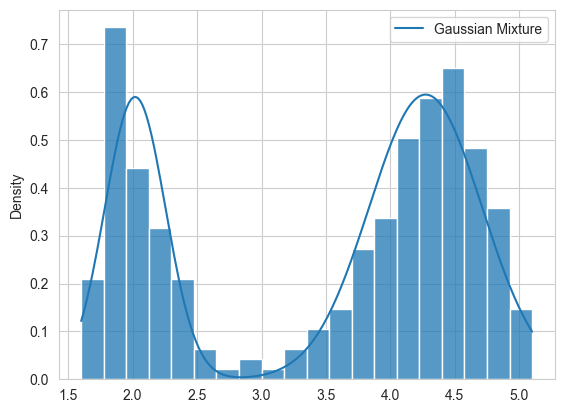

Trial 7


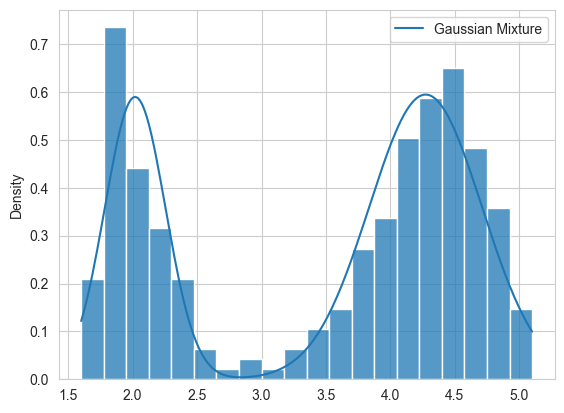

In [43]:
diff_mix = None
diff_loglike = float('-inf')

# Try different initializations
for i in range(7):
    print(f"Trial {i+1}")
    mix = GaussianMixture(data)
    mix.iterate(N=20)

    sns.histplot(data, bins=20, kde=False, stat='density')
    g_both = [mix.pdf(e) for e in x]
    plt.plot(x, g_both, label='Gaussian Mixture')
    plt.legend()
    plt.show()

    if mix.loglike > diff_loglike:
        diff_loglike = mix.loglike
        diff_mix = mix

The EM algorithm, like many optimization algorithms, is sensitive to initialization. If the two Gaussians are initialized too close to each other, the algorithm might converge to a local maximum of the likelihood, effectively identifying only one cluster in the data. Since the EM algorithm only refines the initial guess, it can sometimes get stuck if that guess is too far from the truth. That's why using domain knowledge, data exploration, or multiple initializations followed by choosing the result with the highest likelihood is essential.